# FINAL TASK KALBE NUTRITIONALS DATA SCIENTIST - REGRESSION ARIMA

## A. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm

## B. IMPORT DATASET

In [3]:
df_customer = pd.read_csv('customers.csv', delimiter=';')
df_store = pd.read_csv('store.csv', delimiter=';')
df_transaction = pd.read_csv('transaction.csv', delimiter=';')
df_product = pd.read_csv('product.csv', delimiter=';')

## C. DATA PREPROCESSING

### 1. TRANSACTION DATA

In [4]:
df_transaction.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328  01/01/2022        P3   7500    4        30000   
1       TR16356         165  01/01/2022        P9  10000    7        70000   
2        TR1984         183  01/01/2022        P1   8800    4        35200   
3       TR35256         160  01/01/2022        P1   8800    7        61600   
4       TR41231         386  01/01/2022        P9  10000    1        10000   

   StoreID  
0       12  
1        1  
2        4  
3        4  
4        4

In [5]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [6]:
df_transaction.isna().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [14]:
# SUDAH DIKETAHUI SEBELUMNYA JIKA DALAM DATAFRAME INI TERDAPAT NILAI DUPLIKAT PADA KOLOM 'TransactionID'
df_transaction['TransactionID'].value_counts()

TransactionID
TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: count, Length: 4908, dtype: int64

In [16]:
# MENGURUTKAN DATA DUPLIKAT BERDASARKAN TANGGAL PALING TERAKHIR

df_transaction = df_transaction.sort_values(by='Date', ascending=False)
df_transaction.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
5019       TR85684          55  31/12/2022        P8  16000    1        16000   
5014       TR45899         232  31/12/2022        P6  18000    1        18000   
5013       TR38129         253  31/12/2022        P3   7500    5        37500   
5018       TR85016          18  31/12/2022        P8  16000    3        48000   
5016        TR5604         271  31/12/2022        P2   3200    4        12800   

      StoreID  
5019        6  
5014        9  
5013        4  
5018       13  
5016        9

In [17]:
# MENGHAPUS DATA DUPLIKAT DENGAN MEMPERTAHANKAN DATA yang BERADA DI ATAS

df_transaction = df_transaction.drop_duplicates(subset='TransactionID', keep='first')
df_transaction['TransactionID'].value_counts()

TransactionID
TR85684    1
TR58559    1
TR59286    1
TR57918    1
TR40960    1
          ..
TR79023    1
TR82633    1
TR96435    1
TR36142    1
TR11369    1
Name: count, Length: 4908, dtype: int64

Data sudah tidak memiliki duplikat

### 2. STORE DATA

In [18]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   storeid     14 non-null     int64  
 1   storename   14 non-null     object 
 2   groupstore  14 non-null     object 
 3   Type        14 non-null     object 
 4   latitude    14 non-null     float64
 5   longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 804.0+ bytes


In [32]:
# MENGUBAH NAMA KOLOM

df_store.rename(columns={'storeid': 'StoreID',
                         'storename': 'StoreName', 
                         'groupstore': 'GroupStore', 
                         'latitude': 'Latitude', 
                         'longitude': 'Longitude'
                        }, inplace=True)

df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 804.0+ bytes


### 3. CUSTOMER DATA

In [20]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [22]:
df_customer.head()

CustomerID  Age  Gender Marital Status Income
0           1   55       1        Married   5,12
1           2   60       1        Married   6,23
2           3   32       1        Married   9,17
3           4   31       1        Married   4,87
4           5   58       1        Married   3,57

In [23]:
# MENGUBAH TIPE DATA KOLOM 'Income'

df_customer['Income'] = df_customer['Income'].replace(',', '.', regex=True).astype('float')
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB


In [24]:
df_customer.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [25]:
df_customer['Marital Status'].value_counts()

Marital Status
Married    340
Single     104
Name: count, dtype: int64

In [26]:
# MENGISI NILAI yang KOSONG pada KOLOM 'Marital Status'

df_customer['Marital Status'].fillna('Married', inplace=True)

In [27]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  447 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB


In [61]:
df_customer.sort_values(by='Age', ascending=True)

CustomerID  Age  Gender Marital Status  Income
127         128    0       1        Married    6.77
11           12    2       1        Married    4.94
73           74    3       1        Married    5.09
365         366   18       0         Single    0.00
411         412   18       1         Single    0.00
..          ...  ...     ...            ...     ...
38           39   66       1        Married    6.19
205         206   68       0        Married    8.30
351         352   69       0         Single    6.15
333         334   70       0        Married    5.99
265         266   72       1        Married    4.72

[447 rows x 5 columns]

In [62]:
df_customer[df_customer['Age'] <= 10]

CustomerID  Age  Gender Marital Status  Income
11           12    2       1        Married    4.94
73           74    3       1        Married    5.09
127         128    0       1        Married    6.77

In [67]:
df_customer.loc[df_customer['Age'] < 10, 'Age'] = df_customer['Age'].median()

Empty DataFrame
Columns: [CustomerID, Age, Gender, Marital Status, Income]
Index: []

### 4. PRODUCT DATA

In [28]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes


In [29]:
df_product.isna().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

## C. EXPLORATORY DATA ANALYSIS

### 1. MENGGABUNGKAN DATA

In [68]:
df = pd.merge(df_transaction, df_store, on='StoreID', how='inner')
df.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR85684          55  31/12/2022        P8  16000    1        16000   
1       TR76665         433  31/10/2022        P4  12000    2        24000   
2       TR89427         337  31/07/2022        P5   4200    3        12600   
3       TR35431         163  31/07/2022        P2   3200    4        12800   
4       TR47366          60  31/05/2022        P2   3200    3         9600   

   StoreID StoreName GroupStore          Type  Latitude  Longitude  
0        6    Lingga     Lingga  Modern Trade -5.135399  119.42379  
1        6    Lingga     Lingga  Modern Trade -5.135399  119.42379  
2        6    Lingga     Lingga  Modern Trade -5.135399  119.42379  
3        6    Lingga     Lingga  Modern Trade -5.135399  119.42379  
4        6    Lingga     Lingga  Modern Trade -5.135399  119.42379

In [69]:
df = pd.merge(df, df_customer, on='CustomerID', how='inner')
df.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR85684          55  31/12/2022        P8  16000    1        16000   
1        TR8417          55  24/05/2022        P7   9400    4        37600   
2       TR77543          55  01/09/2022        P5   4200    3        12600   
3         TR578          55  15/07/2022        P4  12000    1        12000   
4       TR12548          55  30/11/2022        P7   9400    2        18800   

   StoreID    StoreName GroupStore           Type  Latitude   Longitude  Age  \
0        6       Lingga     Lingga   Modern Trade -5.135399  119.423790   34   
1        9       Lingga     Lingga   Modern Trade -3.654703  128.190643   34   
2        4  Gita Ginara       Gita  General Trade -6.966667  110.416664   34   
3       13        Buana      Buana  General Trade -1.269160  116.825264   34   
4        3   Prima Kota      Prima   Modern Trade -7.797068  110.370529   34   

   Gender Marital Status  Income  
0       1        Married    8.44  
1       1        Married    8.44  
2       1        Married    8.44  
3       1        Married    8.44  
4       1        Married    8.44

In [70]:
df = pd.merge(df, df_product, on='ProductID', how='inner')
df.head()

TransactionID  CustomerID        Date ProductID  Price_x  Qty  TotalAmount  \
0       TR85684          55  31/12/2022        P8    16000    1        16000   
1       TR76988         433  23/06/2022        P8    16000    2        32000   
2       TR10686         433  28/10/2022        P8    16000    1        16000   
3       TR26760         163  24/03/2022        P8    16000    3        48000   
4       TR39378         163  30/11/2022        P8    16000    1        16000   

   StoreID    StoreName GroupStore           Type  Latitude   Longitude  Age  \
0        6       Lingga     Lingga   Modern Trade -5.135399  119.423790   34   
1        6       Lingga     Lingga   Modern Trade -5.135399  119.423790   48   
2        5      Bonafid       Gita  General Trade -7.250445  112.768845   48   
3        6       Lingga     Lingga   Modern Trade -5.135399  119.423790   47   
4        7  Buana Indah      Buana  General Trade  3.316694  114.590111   47   

   Gender Marital Status  Income Product Name  Price_y  
0       1        Married    8.44          Oat    16000  
1       1        Married   11.97          Oat    16000  
2       1        Married   11.97          Oat    16000  
3       1        Married    6.30          Oat    16000  
4       1        Married    6.30          Oat    16000

In [71]:
df.drop(columns=['Price_x'], inplace=True)
df.rename(columns={'Price_y': 'Price'}, inplace=True)
df.head()

TransactionID  CustomerID        Date ProductID  Qty  TotalAmount  StoreID  \
0       TR85684          55  31/12/2022        P8    1        16000        6   
1       TR76988         433  23/06/2022        P8    2        32000        6   
2       TR10686         433  28/10/2022        P8    1        16000        5   
3       TR26760         163  24/03/2022        P8    3        48000        6   
4       TR39378         163  30/11/2022        P8    1        16000        7   

     StoreName GroupStore           Type  Latitude   Longitude  Age  Gender  \
0       Lingga     Lingga   Modern Trade -5.135399  119.423790   34       1   
1       Lingga     Lingga   Modern Trade -5.135399  119.423790   48       1   
2      Bonafid       Gita  General Trade -7.250445  112.768845   48       1   
3       Lingga     Lingga   Modern Trade -5.135399  119.423790   47       1   
4  Buana Indah      Buana  General Trade  3.316694  114.590111   47       1   

  Marital Status  Income Product Name  Price  
0        Married    8.44          Oat  16000  
1        Married   11.97          Oat  16000  
2        Married   11.97          Oat  16000  
3        Married    6.30          Oat  16000  
4        Married    6.30          Oat  16000

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   4908 non-null   object 
 1   CustomerID      4908 non-null   int64  
 2   Date            4908 non-null   object 
 3   ProductID       4908 non-null   object 
 4   Qty             4908 non-null   int64  
 5   TotalAmount     4908 non-null   int64  
 6   StoreID         4908 non-null   int64  
 7   StoreName       4908 non-null   object 
 8   GroupStore      4908 non-null   object 
 9   Type            4908 non-null   object 
 10  Latitude        4908 non-null   float64
 11  Longitude       4908 non-null   float64
 12  Age             4908 non-null   int64  
 13  Gender          4908 non-null   int64  
 14  Marital Status  4908 non-null   object 
 15  Income          4908 non-null   float64
 16  Product Name    4908 non-null   object 
 17  Price           4908 non-null   i

In [72]:
# MENGUBAH TIPE DATA KOLOM 'Date'

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   4908 non-null   object        
 1   CustomerID      4908 non-null   int64         
 2   Date            4908 non-null   datetime64[ns]
 3   ProductID       4908 non-null   object        
 4   Qty             4908 non-null   int64         
 5   TotalAmount     4908 non-null   int64         
 6   StoreID         4908 non-null   int64         
 7   StoreName       4908 non-null   object        
 8   GroupStore      4908 non-null   object        
 9   Type            4908 non-null   object        
 10  Latitude        4908 non-null   float64       
 11  Longitude       4908 non-null   float64       
 12  Age             4908 non-null   int64         
 13  Gender          4908 non-null   int64         
 14  Marital Status  4908 non-null   object        
 15  Inco

In [73]:
df.describe()

CustomerID                           Date          Qty   TotalAmount  \
count  4908.000000                           4908  4908.000000   4908.000000   
mean    221.299307  2022-06-29 10:48:59.853300480     3.645273  32298.859006   
min       1.000000            2022-01-01 00:00:00     1.000000   7500.000000   
25%     108.000000            2022-03-30 00:00:00     2.000000  16000.000000   
50%     221.000000            2022-06-26 00:00:00     3.000000  28200.000000   
75%     332.000000            2022-09-28 00:00:00     5.000000  47000.000000   
max     447.000000            2022-12-31 00:00:00    10.000000  88000.000000   
std     129.673195                            NaN     1.852048  19642.417147   

           StoreID     Latitude    Longitude          Age       Gender  \
count  4908.000000  4908.000000  4908.000000  4908.000000  4908.000000   
mean      7.490016    -2.948846   109.602849    40.209454     0.453545   
min       1.000000    -7.797068    95.323753    18.000000     0.000000   
25%       4.000000    -6.914864   104.756554    31.000000     0.000000   
50%       7.000000    -5.135399   110.370529    39.000000     0.000000   
75%      11.000000     0.533505   114.590111    51.000000     1.000000   
max      14.000000     5.548290   128.190643    72.000000     1.000000   
std       4.030870     4.319213     8.351611    12.463492     0.497888   

            Income         Price  
count  4908.000000   4908.000000  
mean      8.597266   9691.198044  
min       0.000000   3200.000000  
25%       4.220000   4200.000000  
50%       7.720000   9400.000000  
75%      10.780000  15000.000000  
max      71.300000  18000.000000  
std       6.425242   4604.601586

array([[<Axes: title={'center': 'CustomerID'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Qty'}>],
       [<Axes: title={'center': 'TotalAmount'}>,
        <Axes: title={'center': 'StoreID'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>],
       [<Axes: title={'center': 'Income'}>,
        <Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

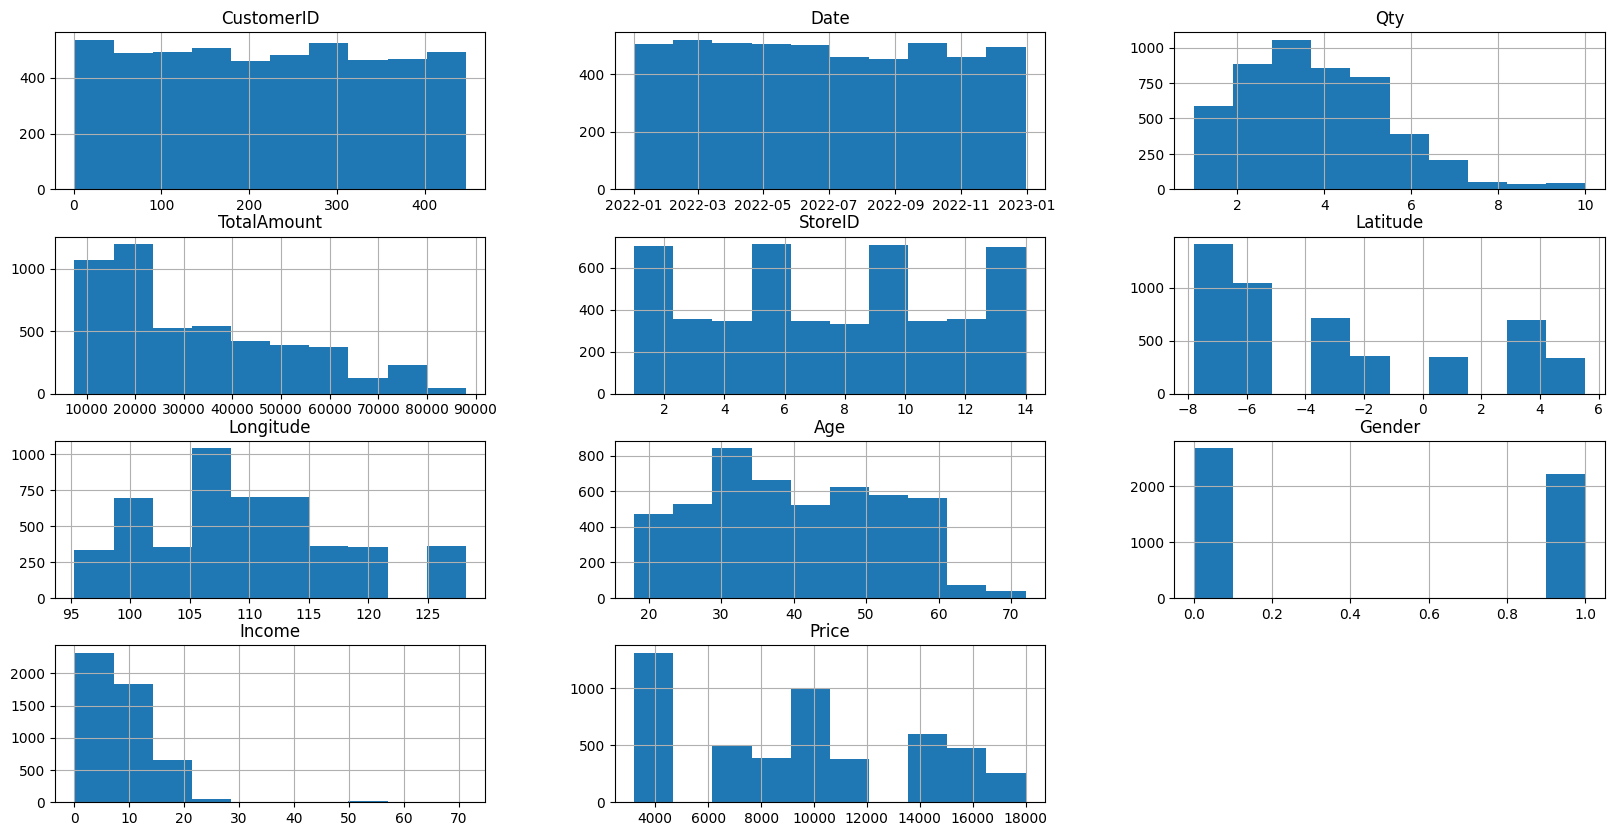

In [74]:
df.hist(figsize=(20, 10))

In [50]:
num_column = ['Qty', 'TotalAmount', 'Price', 'Longitude', 'Latitude', 'Age', 'Income']

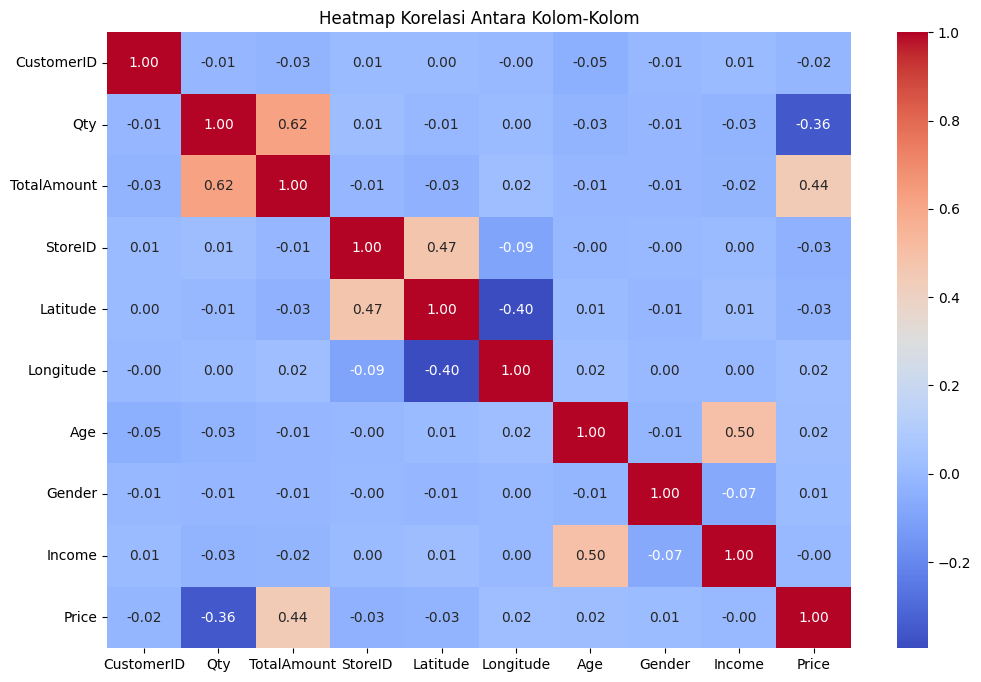

In [75]:
df_numeric = df.select_dtypes(include=[float, int])
corr_matrix = df_numeric.corr()

# Membuat heatmap dari korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antara Kolom-Kolom')
plt.show()

In [79]:
group_df = df.groupby(by='Date').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
})
group_df.head()

TransactionID  Qty  TotalAmount
Date                                       
2022-01-01             12   47       399200
2022-01-02             14   54       540800
2022-01-03             18   63       561300
2022-01-04             17   43       376500
2022-01-05              9   23       203400

## D. TIME SERIES ARIMA

### 1. DATA PREPARATION

In [80]:
arima_df = df.groupby('Date').agg({
    'Qty': 'sum'
}).reset_index()
arima_df.set_index('Date', inplace=True)
arima_df

Qty
Date           
2022-01-01   47
2022-01-02   54
2022-01-03   63
2022-01-04   43
2022-01-05   23
...         ...
2022-12-27   70
2022-12-28   68
2022-12-29   42
2022-12-30   44
2022-12-31   37

[365 rows x 1 columns]

### 2. VISUALISASI

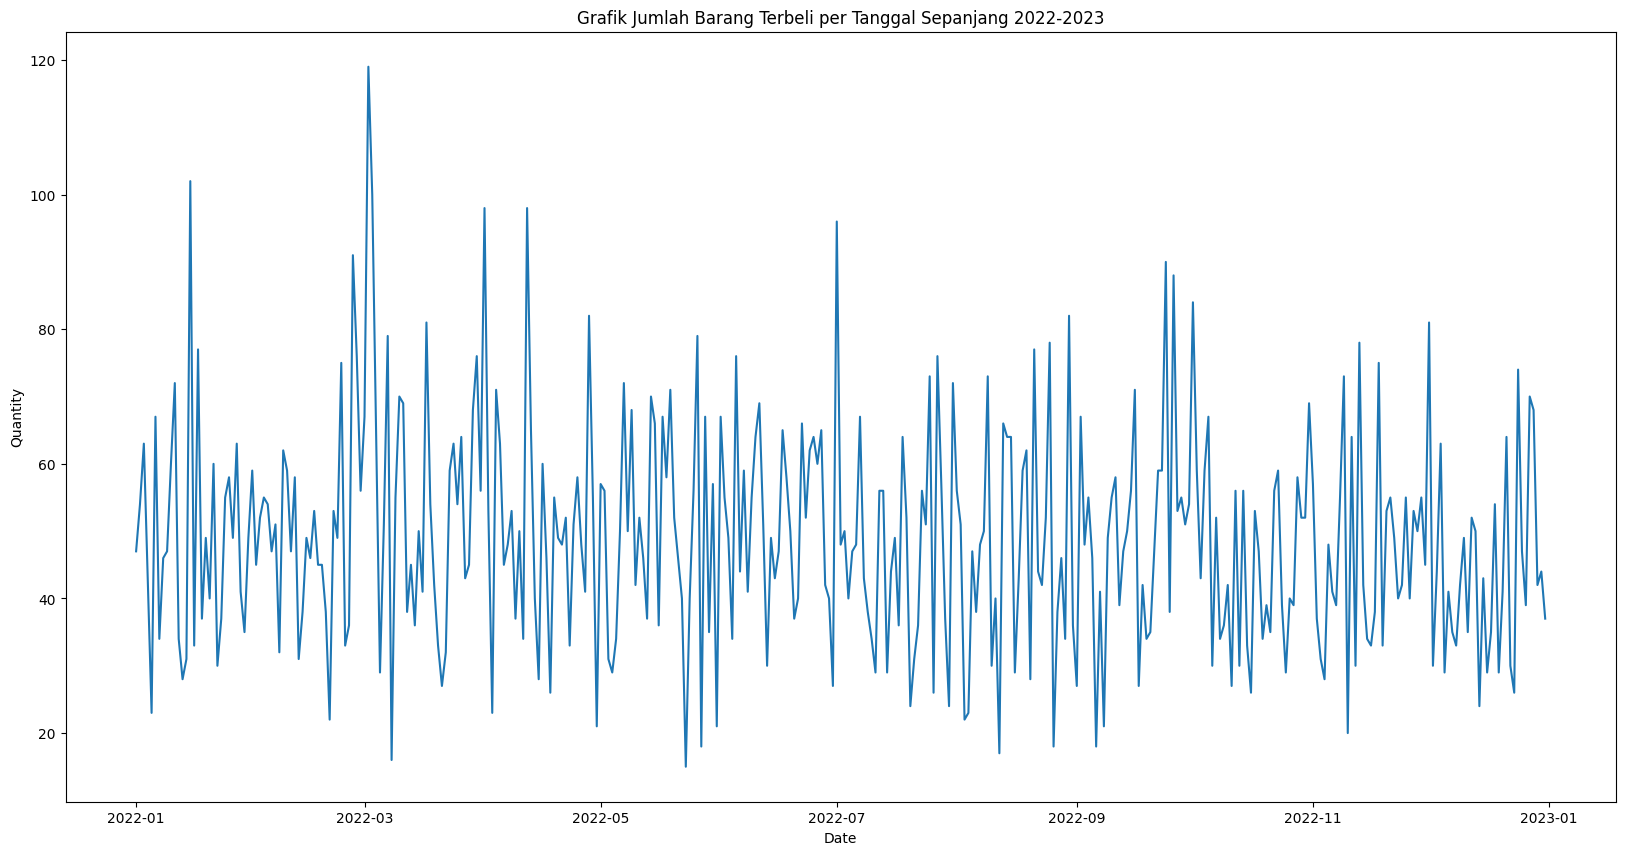

In [81]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.plot(arima_df['Qty'])
plt.title('Grafik Jumlah Barang Terbeli per Tanggal Sepanjang 2022-2023')
plt.show()

### 3. DECOMPOSED

In [83]:
import statsmodels.api as sm

decompose = sm.tsa.seasonal_decompose(arima_df, model='additive')

In [84]:
# MODEL TIME SERIES

trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

In [85]:
# PENGUJIAN APAKAH DATA MUSIMAN atau TIDAK

is_seasonal = (abs(seasonal - seasonal.mean()) > 0.05 * seasonal.std()).any()

if is_seasonal:
    print('Data bersifat musiman')
else:
    print('Data tidak bersifat musiman')

Data bersifat musiman


In [88]:
# MENDEFINISKAN FUNGSI untuk ADF TEST

from statsmodels.tsa.stattools import adfuller

def test_adf(series):
    result = adfuller(series)
    print('ADF Statistics: %f ' % result [0])
    print('p-value: %f' % result [1])
    print('Critical Value:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        if result[1] <= 0.05:
            print('Hasil Uji Data: Stasioner')
        else:
            print('hasil Uji Data: Non-Stasioner')

test_adf(arima_df)

ADF Statistics: -19.225949 
p-value: 0.000000
Critical Value:
	1%: -3.448
Hasil Uji Data: Stasioner
	5%: -2.870
Hasil Uji Data: Stasioner
	10%: -2.571
Hasil Uji Data: Stasioner


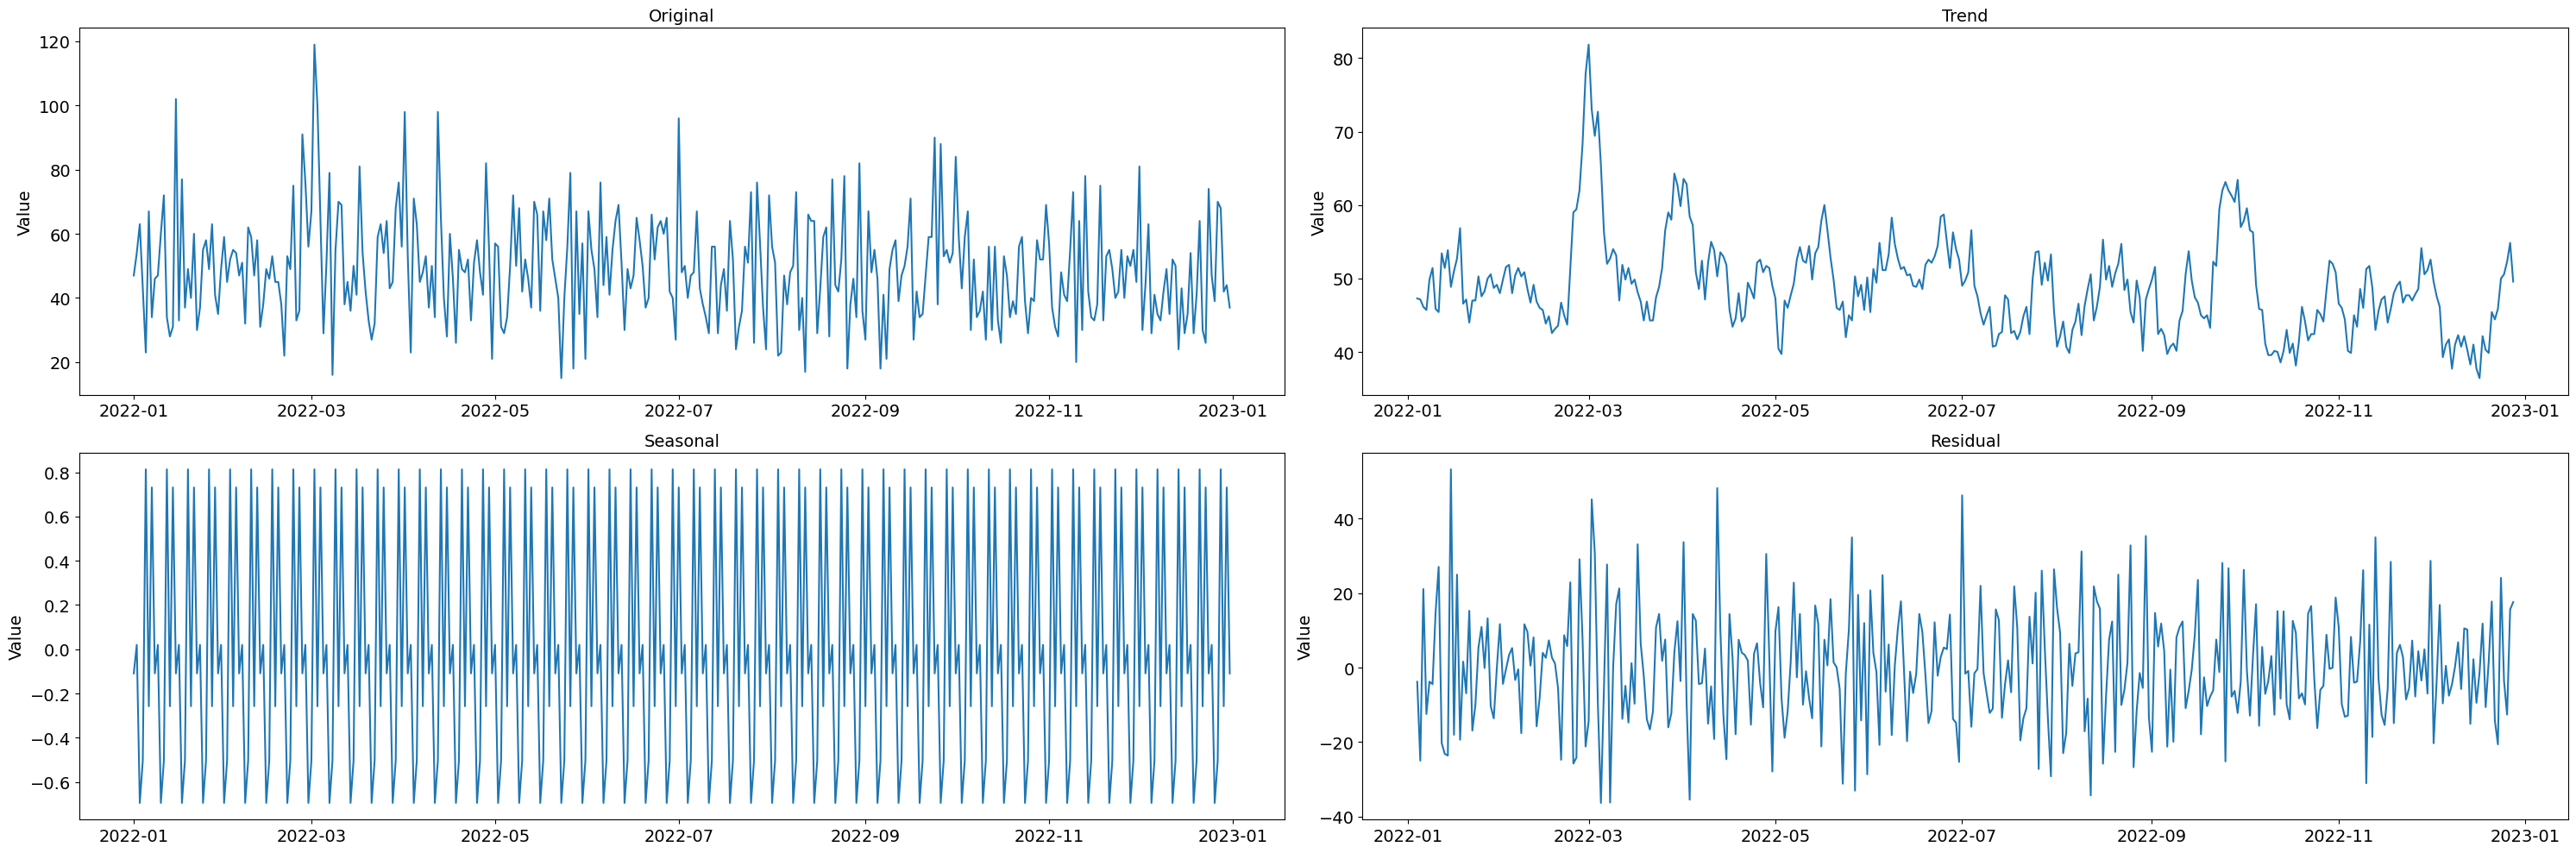

In [89]:
# DEKOMPOSISI DATA MENJADI KOMPONEN TREND, SEASONAL, RESIDUAL

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(arima_df, model='additive')
fig, axes = plt.subplots(2, 2, figsize=(30, 10))  

axes[0, 0].set_title('Original', fontsize=14)  
axes[0, 0].plot(result.observed)
axes[0, 0].tick_params(axis='both', which='major', labelsize=14)
axes[0, 0].set_xlabel('', fontsize=14)  
axes[0, 0].set_ylabel('Value', fontsize=14) 

axes[0, 1].set_title('Trend', fontsize=14)
axes[0, 1].plot(result.trend)
axes[0, 1].tick_params(axis='both', which='major', labelsize=14)
axes[0, 1].set_xlabel('', fontsize=14)  
axes[0, 1].set_ylabel('Value', fontsize=14) 

axes[1, 0].set_title('Seasonal', fontsize=14)
axes[1, 0].plot(result.seasonal)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)
axes[1, 0].set_xlabel('', fontsize=14)  
axes[1, 0].set_ylabel('Value', fontsize=14) 

axes[1, 1].set_title('Residual', fontsize=14)
axes[1, 1].plot(result.resid)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14)
axes[1, 1].set_xlabel('', fontsize=14)  
axes[1, 1].set_ylabel('Value', fontsize=14) 

# Tampilkan plot
plt.tight_layout()
plt.show()

## 4. DATA TRANSFORMATION

In [94]:
from scipy.stats import boxcox

transformed_data, lambda_value = boxcox(arima_df['Qty'])

transform = arima_df.copy()
transform['Qty'] = transformed_data

print(f'Nilai lambda = {round(lambda_value, 3)} sehingga transformasi menggunakan √y')

Nilai lambda = 0.384 sehingga transformasi menggunakan √y


In [95]:
# TRANSFORMASI DATA √y

arima_df['Qty'] = np.sqrt(arima_df['Qty'])

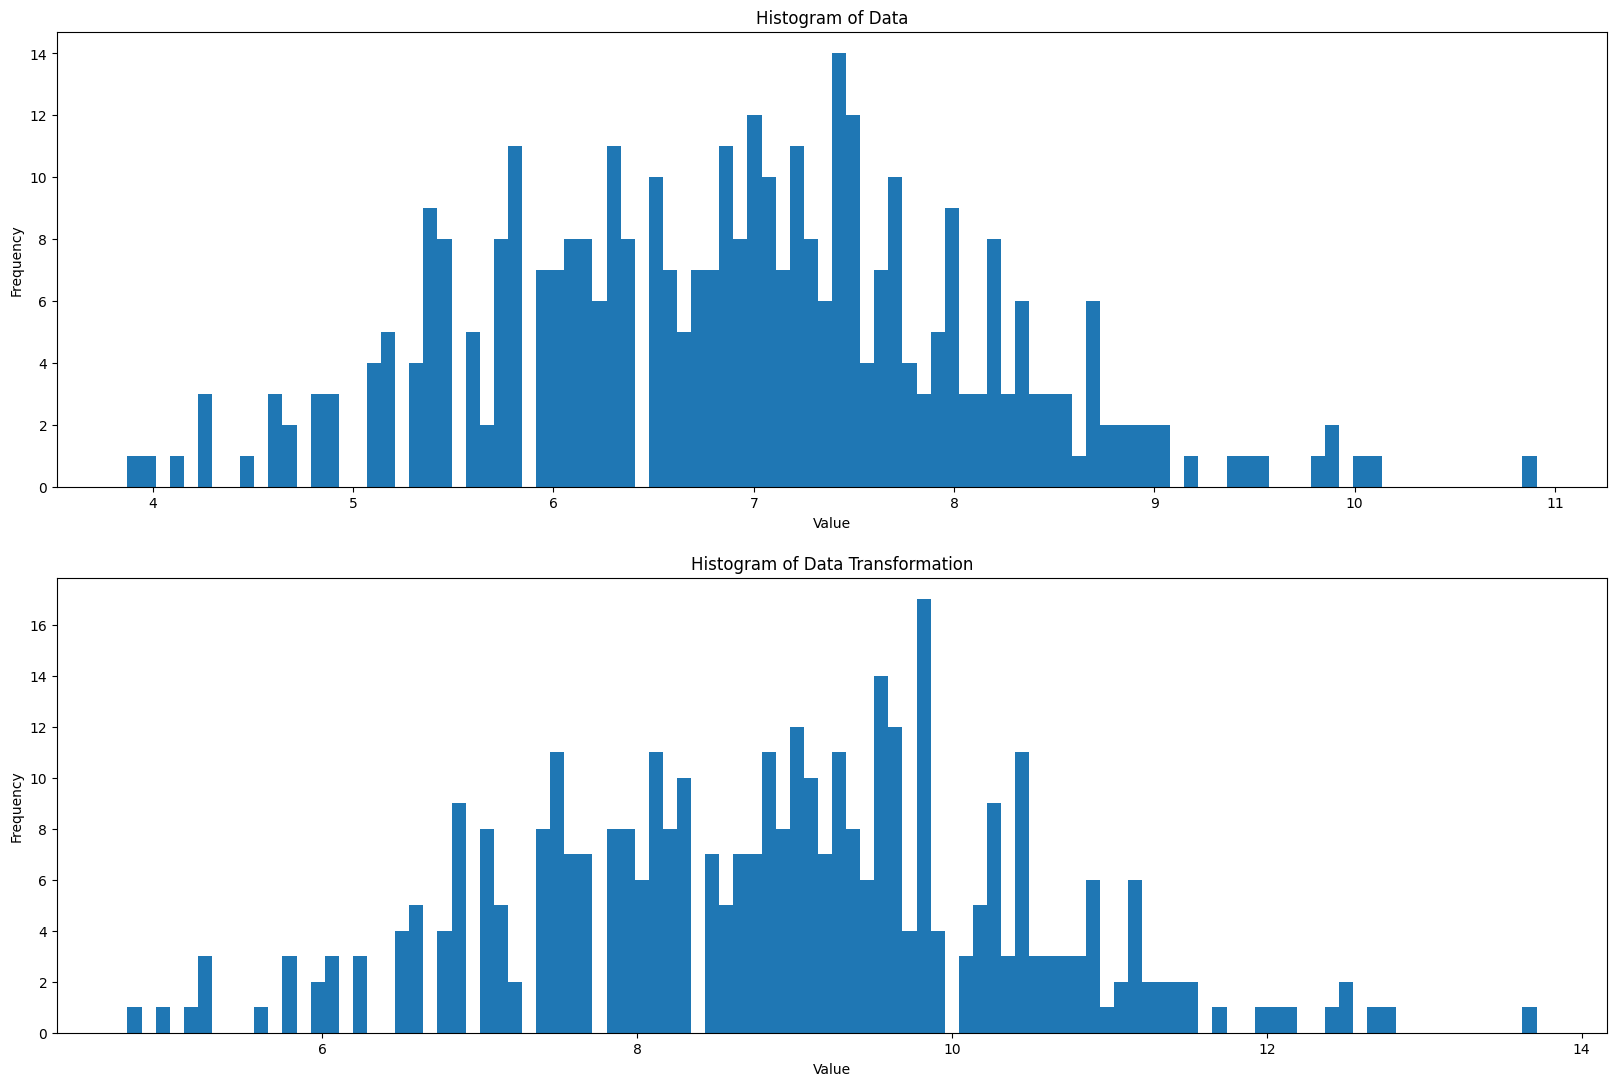

In [96]:
# PLOT HISTOGRAM

# Plot the histogram
plt.figure(figsize=(20,13))

plt.subplot(2, 1, 1)
plt.hist(arima_df['Qty'], bins=100)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data")

plt.subplot(2, 1, 2)
plt.hist(transform['Qty'], bins=100)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data Transformation")
plt.show()

## MODELLING

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1591.526, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1396.661, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1461.188, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1368.938, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1474.145, Time=0.33 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1337.957, Time=0.69 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1374.625, Time=0.27 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.46 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.18 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1302.970, Time=0.74 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1339.753, Time=0.33 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=i

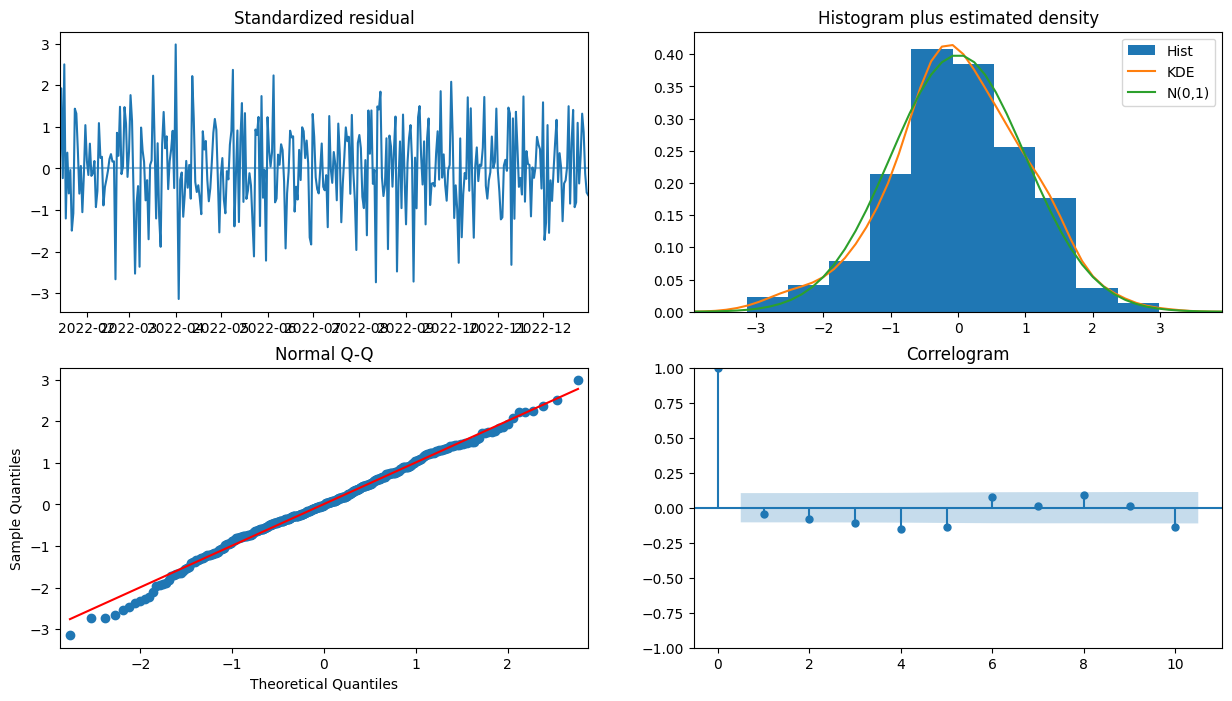

In [97]:
model_autoARIMA = pm.auto_arima(arima_df, start_p=0, start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=4, max_q=43, # maximum p and q
                             m=12,              # frequency of series
                             d=1,           # let model determine 'd'
                             seasonal=True,   # With Seasonality
                             start_P=0,
                             D=1,
                             start_Q=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

### HASIL PERMODELAN

1. Asumsi tentang Autokorelasi:

Hasil uji Ljung-Box (Q) menunjukkan nilai 0.62 dengan Prob(Q) sebesar 0.43.
Nilai Prob(Q) yang tinggi menunjukkan bahwa tidak ada cukup bukti untuk menolak hipotesis nol bahwa tidak ada autokorelasi dalam sisa (residuals) model.
Oleh karena itu, model SARIMA memenuhi asumsi tentang autokorelasi, karena tidak ada cukup bukti untuk menolak bahwa residual model bebas dari autokorelasi.


2. Asumsi tentang Distribusi Residual:

Hasil uji Jarque-Bera (JB) menunjukkan nilai 1.96 dengan Prob(JB) sebesar 0.23.
Nilai Prob(JB) yang tinggi menunjukkan bahwa tidak ada cukup bukti untuk menolak hipotesis nol bahwa data residu berasal dari distribusi normal.
Oleh karena itu, model SARIMA juga memenuhi asumsi tentang distribusi residu, karena tidak ada cukup bukti untuk menolak bahwa residu berasal dari distribusi normal.


3. Asumsi tentang Heteroskedastisitas:

Hasil uji Heteroskedastisitas menunjukkan nilai 0.83 dengan Prob(H) (two-sided) sebesar 0.33.
Nilai Prob(H) yang tinggi menunjukkan bahwa tidak ada cukup bukti untuk menolak hipotesis nol bahwa residu model homoskedastik (variansi konstan).
Oleh karena itu, model SARIMA juga memenuhi asumsi tentang homoskedastisitas residu, karena tidak ada cukup bukti untuk menolak bahwa residu memiliki variansi konstan.

## PREDIKSI MODEL

### TEST TRAIN SPLIT

In [98]:
from pmdarima.model_selection import train_test_split

train, test = train_test_split(arima_df, train_size=0.7)

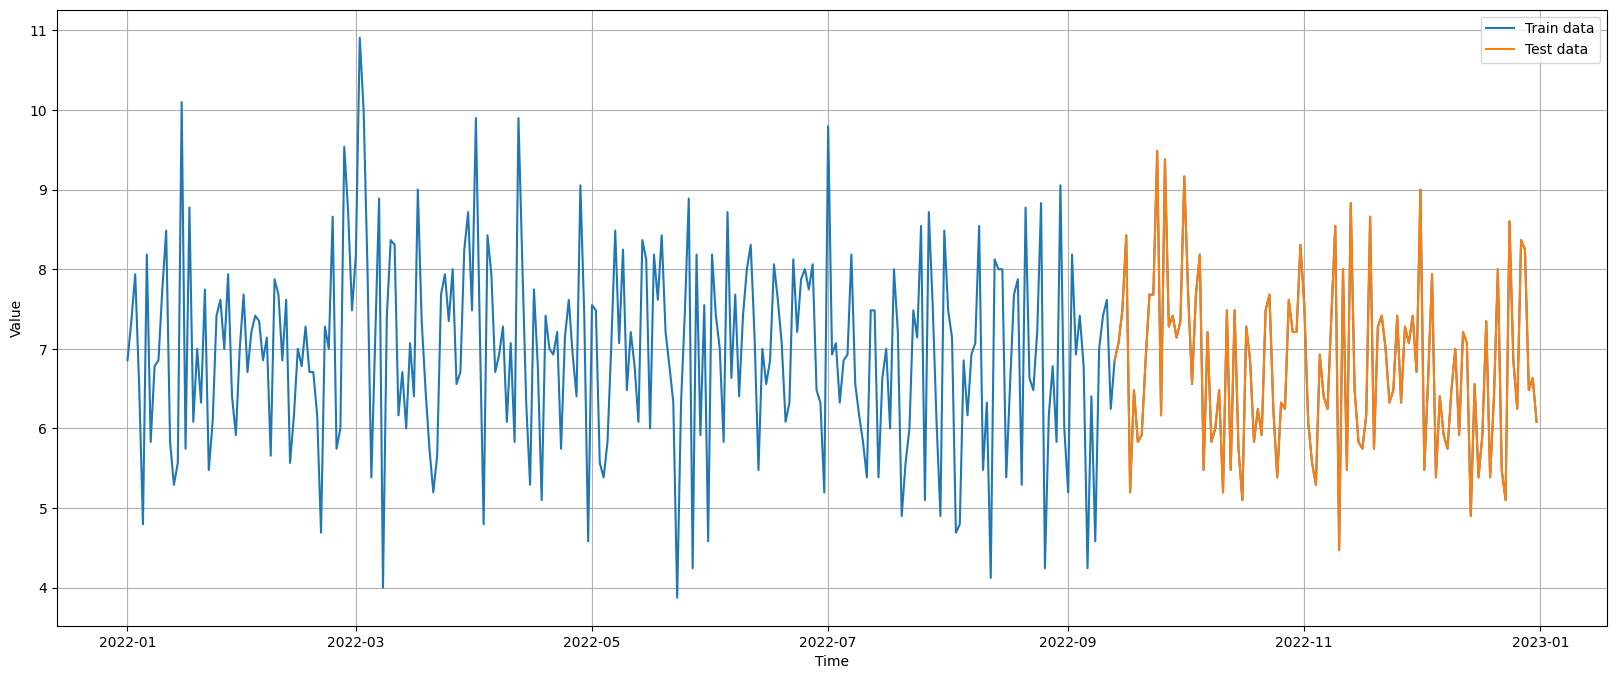

In [99]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(arima_df, label='Train data')
plt.plot(test,label='Test data')
plt.legend()

### FITTING MODEL

In [100]:
# Assuming 'df_arima' is your time series data (e.g., a pandas DataFrame or Series)
# Set the frequency of the data appropriately (e.g., 'D' for daily, 'M' for monthly, etc.)
# Change 'freq' to the appropriate frequency of your data
arima_df = arima_df.asfreq(freq='D')

# Using the same parameters of the fitted model
# Order based on SARIMA Model with the smallest AIC value
best_model = sm.tsa.statespace.SARIMAX(arima_df, order=(4, 1, 0), seasonal_order=(2, 1, 0, 12), trend='c')

# Fitting the SARIMA model to the data
best_result = best_model.fit(disp=True)

In [101]:
best_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                Qty   No. Observations:                  365
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -638.402
Date:                            Sat, 21 Oct 2023   AIC                           1292.804
Time:                                    02:12:10   BIC                           1323.713
Sample:                                01-01-2022   HQIC                          1305.104
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0046      0.083      0.055      0.956      -0.158       0.168
ar.L1         -0.8269      0.058    -14.334      0.000      -0.940      -0.714
ar.L2         -0.6211      0.072     -8.592      0.000      -0.763      -0.479
ar.L3         -0.4722      0.067     -7.039      0.000      -0.604      -0.341
ar.L4         -0.1992      0.052     -3.867      0.000      -0.300      -0.098
ar.S.L12      -0.6171      0.053    -11.604      0.000      -0.721      -0.513
ar.S.L24      -0.3302      0.055     -6.024      0.000      -0.438      -0.223
sigma2         2.1607      0.158     13.675      0.000       1.851       2.470
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 2.96
Prob(Q):                              0.43   Prob(JB):                         0.23
Heteroskedasticity (H):               0.83   Skew:                            -0.19
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
test['Predict'] = best_result.predict(start=(len(train)), end=(len(train)+len(test)+3))

In [103]:
best_result_residual = best_result.resid

## PREDIKSI BERDASAKAN DATA TEST

In [104]:
test['Predict']

Date
2022-09-13    5.904478
2022-09-14    9.053567
2022-09-15    6.427606
2022-09-16    6.666372
2022-09-17    6.494406
                ...   
2022-12-27    6.437037
2022-12-28    6.971202
2022-12-29    6.667776
2022-12-30    7.489965
2022-12-31    7.031887
Name: Predict, Length: 110, dtype: float64

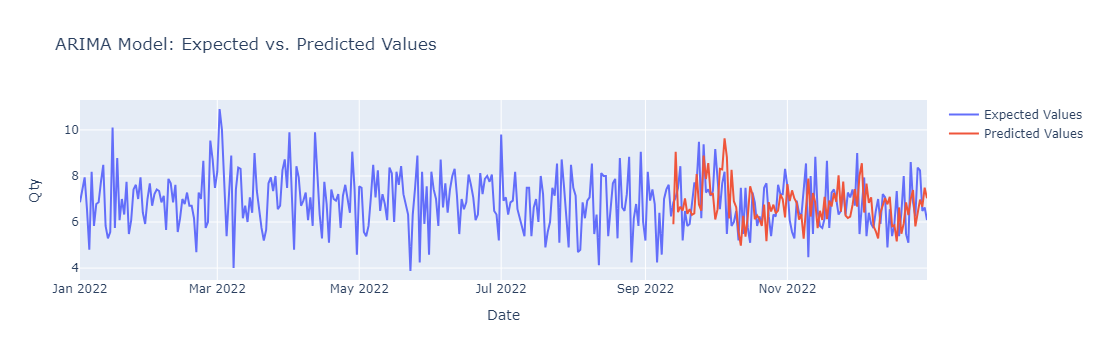

In [105]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add trace for the actual values
fig.add_trace(go.Scatter(x=arima_df.index, y=arima_df['Qty'], mode='lines', name='Expected Values'))

# Add trace for the predicted values
fig.add_trace(go.Scatter(x=test.index, y=test['Predict'], mode='lines', name='Predicted Values'))

# Update layout
fig.update_layout(title='ARIMA Model: Expected vs. Predicted Values',
                  xaxis_title='Date', yaxis_title='Qty')

# Show the plot
fig.show()

### EVALUASI MODEL

In [107]:
# Calculate the evaluation metrics
mae = np.mean(np.abs(best_result_residual))
mse = np.mean(best_result_residual**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(best_result_residual / arima_df['Qty'])) * 100
mad = sm.robust.scale.mad(best_result_residual)
# Print the evaluation metrics
print('MAE:', mae)
print("MAPE:", mape)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAD:', mad)

MAE: 1.1916503990229985
MAPE: 18.22949141187862
MSE: 2.404227765848353
RMSE: 1.5505572436541493
MAD: 1.383923219067751


In [108]:
predict_6month = best_result.predict(start=(len(arima_df)), end=(len(arima_df)+5))

In [109]:
# MENGEMBALIKAN NILAI y

predict_6month = np.square(predict_6month)
predict_6month

2023-01-01    48.450474
2023-01-02    62.288155
2023-01-03    45.645436
2023-01-04    39.988617
2023-01-05    63.305195
2023-01-06    65.567731
Freq: D, Name: predicted_mean, dtype: float64

### VISUALISASI

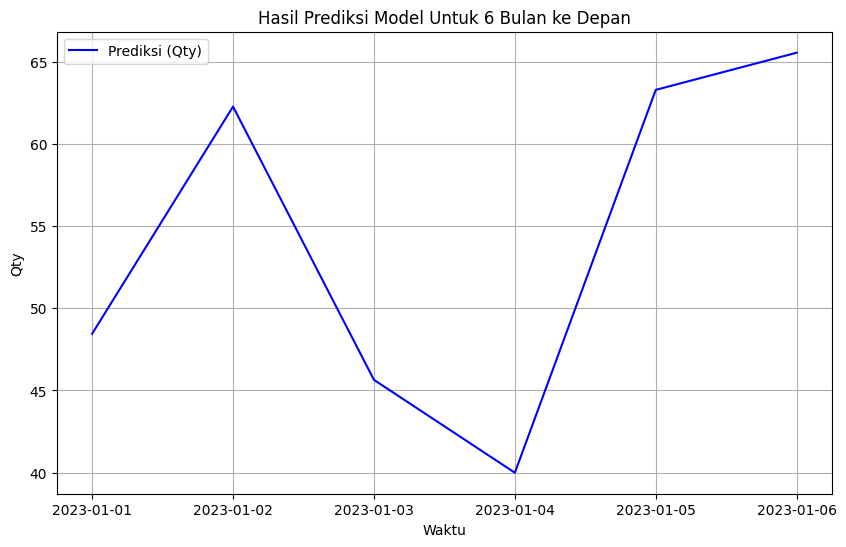

In [114]:
# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(predict_6month, label='Prediksi (Qty)', color='blue')

# Tambahkan judul dan label sumbu
plt.title('Hasil Prediksi Model Untuk 6 Bulan ke Depan')
plt.xlabel('Waktu')
plt.ylabel('Qty')
plt.grid()

# Menampilkan legenda
plt.legend()

# Tampilkan plot
plt.show()